## Training a Classifier based on TResNet
To follow the best practices provided by the official, this notebook is adapted from [pytorch tutorial](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py). If you are familiar with pytorch, you can skip the introduction.

### What about data?
Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.
-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful
   
Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.
This provides a huge convenience and avoids writing boilerplate code.
For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

### Training an image classifier
We will do the following steps in order:
1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data
1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
opt_level = 'O1'
gpu = 0

In [3]:
device = torch.device("cuda:{}".format(gpu) if torch.cuda.is_available() else "cpu")

#### Load and normalizing the CIFAR10 training and test datasets

In [4]:
# no need to use transforms.Normalize, see https://github.com/mrT23/TResNet/issues/5#issuecomment-608440989
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./cifar10_data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar10_data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Let us show some of the training images, for fun.

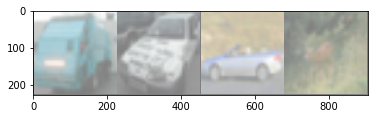

truck   car   car  deer


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Define a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [6]:
# !pip install torch_tresnet

In [7]:
from torch_tresnet import tresnet_xl

net = tresnet_xl(pretrained=True, num_classes=10, in_chans=3).to(device)

#### Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [8]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### Train the network

* This is when things start to get interesting.
* We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

The original paper uses mixed precision. Here `apex` is required:
```
$ git clone https://github.com/NVIDIA/apex
$ cd apex
$ pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
```

In [9]:
from apex import amp

net, optimizer = amp.initialize(net, optimizer, opt_level=opt_level)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [11]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
#         loss.backward()
        
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()

        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
[1,  2000] loss: 0.776
[1,  4000] loss: 0.463
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
[1,  6000] loss: 0.391
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
[1,  8000] loss: 0.318
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
[1, 10000] loss: 0.322
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
[1, 12000] loss: 0.269
[2,  2000] loss: 0.175
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
[2,  4000] loss: 0.179
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
[2,  6000] loss: 0.169
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
[2,  8000] loss: 0.156
Gradient overflow.  Skipping step, loss scaler 0 red

#### Let's quickly save our trained model:
See [here](https://pytorch.org/docs/stable/notes/serialization.html) for more details on saving PyTorch models.

In [12]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

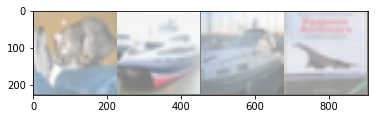

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

########################################################################
# Next, let's load back in our saved model (note: saving and re-loading the model
# wasn't necessary here, we only did it to illustrate how to do so):

net.load_state_dict(torch.load(PATH))

########################################################################
# Okay, now let us see what the neural network thinks these examples above are:

outputs = net(images)

########################################################################
# The outputs are energies for the 10 classes.
# The higher the energy for a class, the more the network
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [18]:
########################################################################
# The results seem pretty good.
#
# Let us look at how the network performs on the whole dataset.

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 93 %


In [19]:
########################################################################
# That looks way better than chance, which is 10% accuracy (randomly picking
# a class out of 10 classes).
# Seems like the network learnt something.
#
# Hmmm, what are the classes that performed well, and the classes that did
# not perform well:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 92 %
Accuracy of   car : 97 %
Accuracy of  bird : 91 %
Accuracy of   cat : 89 %
Accuracy of  deer : 91 %
Accuracy of   dog : 90 %
Accuracy of  frog : 95 %
Accuracy of horse : 96 %
Accuracy of  ship : 96 %
Accuracy of truck : 95 %
